In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# !! need to insert this path to load h5py without errors!
#  (otherwise Python tries to load the h5py in default site-packages and throws an ImportError)
import sys
sys.path.insert(0, '/work2/08811/aew492/frontera/venv/illustris3.9/lib/python3.9/site-packages')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
import pickle
import astropy.units as u
import astropy.cosmology.units as cu
import os
import illustris_python as il

sys.path.insert(0, '/work2/08811/aew492/frontera/small-scale_cross-corrs/code')
from xcorr_cases import HSC_Xcorr
import tools

In [5]:
# main inputs
snapshotss = [
    np.arange(59, 84), # center at z~0.45
    np.arange(47, 70), # center at z=0.75
    np.arange(40, 62),  # center at z=1.
    np.arange(35, 54)  # center at z=1.25
]

# the photo-z bins
photzbins = np.arange(0, 4)

# galaxy number density
densities = [1e-4 * (cu.littleh / u.Mpc)**3,
             4e-4 * (cu.littleh / u.Mpc)**3,
             1e-3 * (cu.littleh / u.Mpc)**3,
             2e-3 * (cu.littleh / u.Mpc)**3]

# reference tracers
tracers = ['ELG', 'LRG']

hsc_kwargs = dict(density_type='fixed', reference_survey='DESI')

In [6]:
for (snapshots, photzbin) in zip(snapshotss, photzbins):
    # instantiate
    X = HSC_Xcorr(snapshots, photzbin, density=4e-4, reference_tracer='ELG', **hsc_kwargs)

    mean_snapshot = np.mean(X.snapshots)
    mean_z = np.mean(X.redshifts)
    print(mean_snapshot, mean_z)
    central_chi = tools.redshift_to_comov(mean_z).value
    print(central_chi)
    i = np.argmin(np.abs(X.chis - X.central_chi))
    print(i, X.chis[i].value, X.snapshots[i], X.redshifts[i], X.redshifts[i-1], X.redshifts[i+1])
    print(X.central_chi) # == np.mean(X.chis)
    print("")

71.0 0.43320000000000003
1162.7557487015847
12 1131.3550914202156 71 0.42 0.4 0.44
1147.8557824140503 Mpc / littleh

58.0 0.7504347826086957
1846.974975843601
11 1806.751626651671 58 0.73 0.7 0.76
1824.4829156945123 Mpc / littleh

50.5 1.0059090909090909
2310.328887972798
11 2300.3862583321006 50 1.0 0.95 1.04
2280.5029418391227 Mpc / littleh

44.0 1.2905263157894737
2751.308123821217
9 2692.7689377451798 44 1.25 1.21 1.3
2720.399285972595 Mpc / littleh



/tmp/ipykernel_269448/3778410324.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9,6))


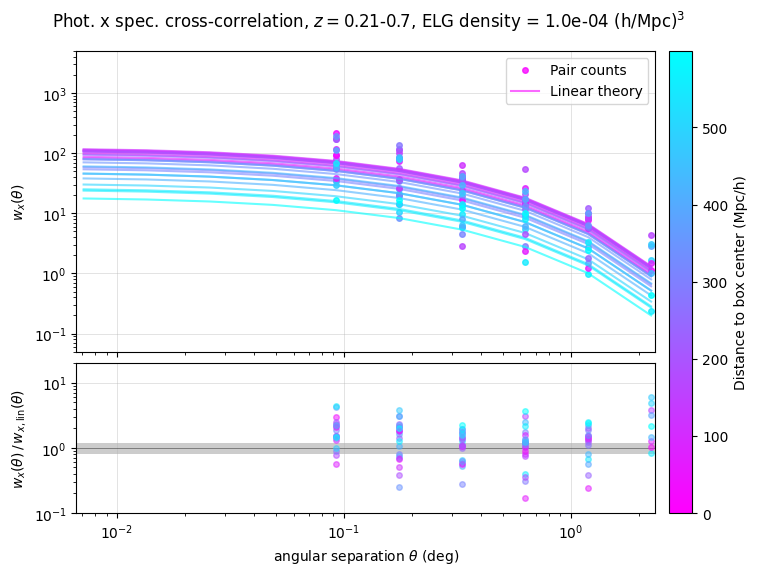

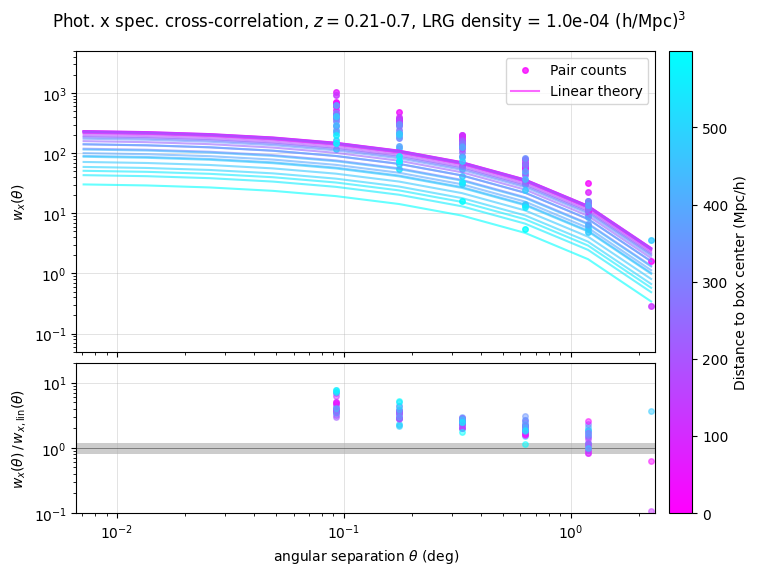

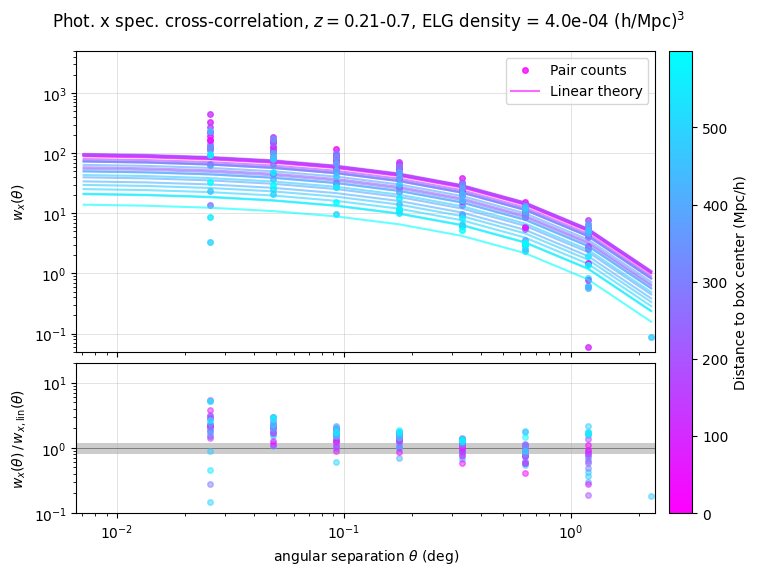

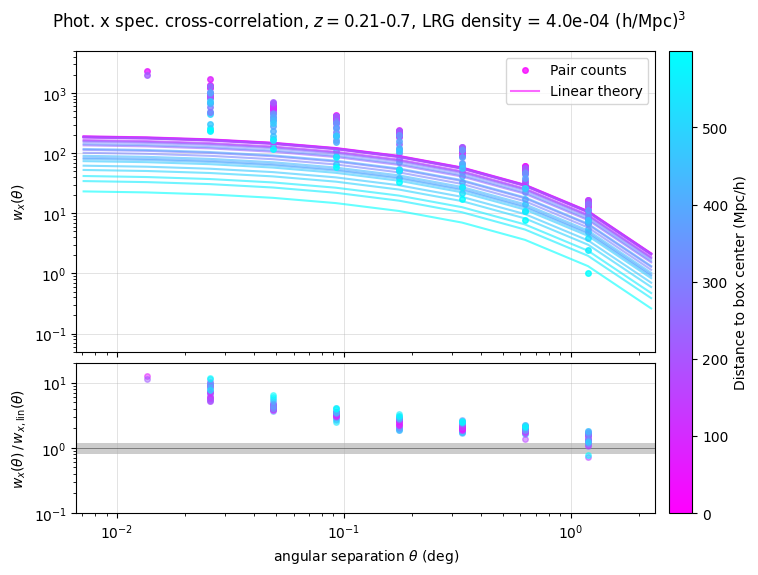

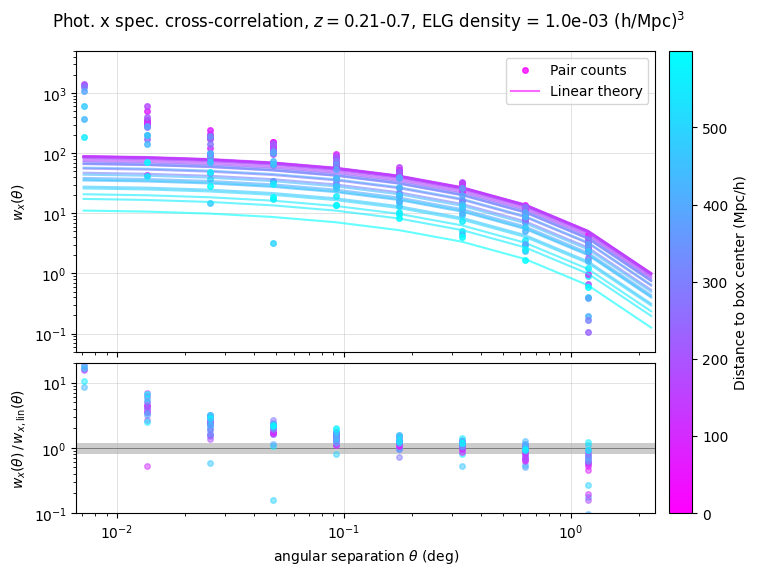

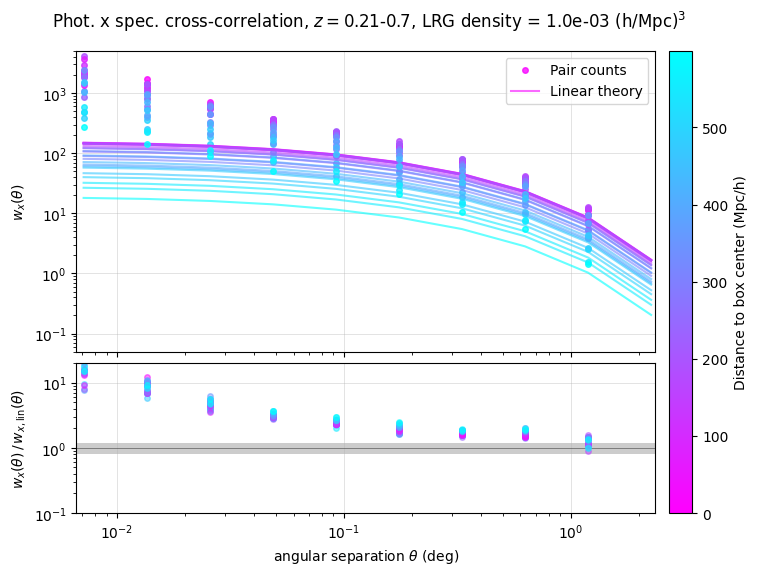

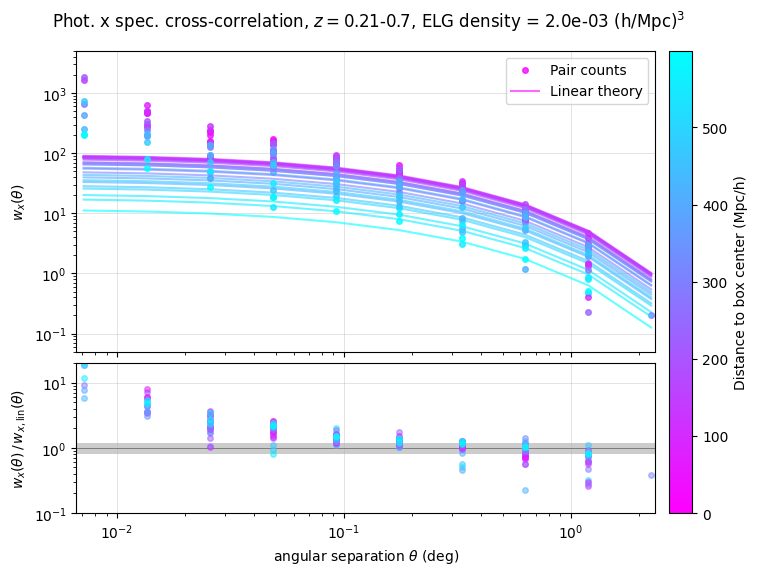

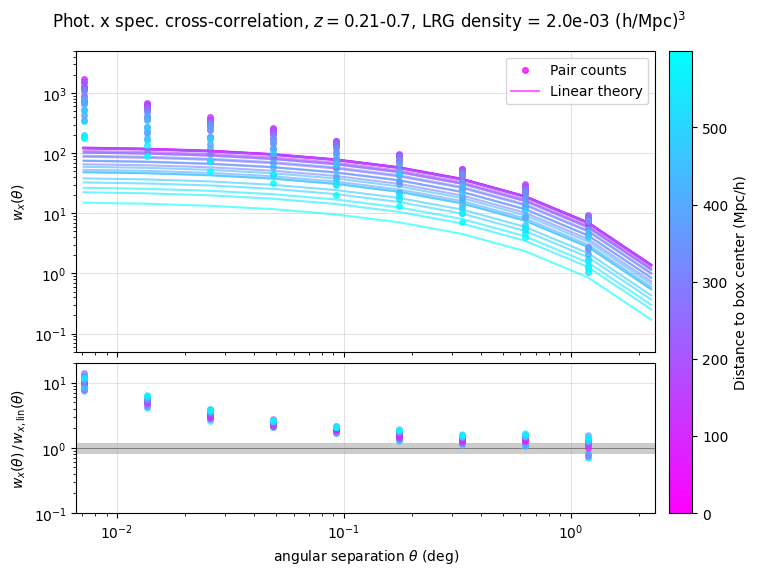

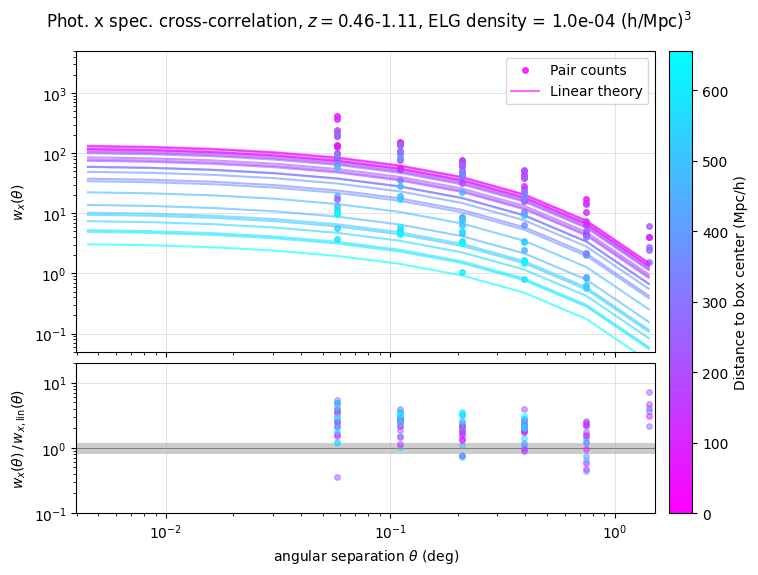

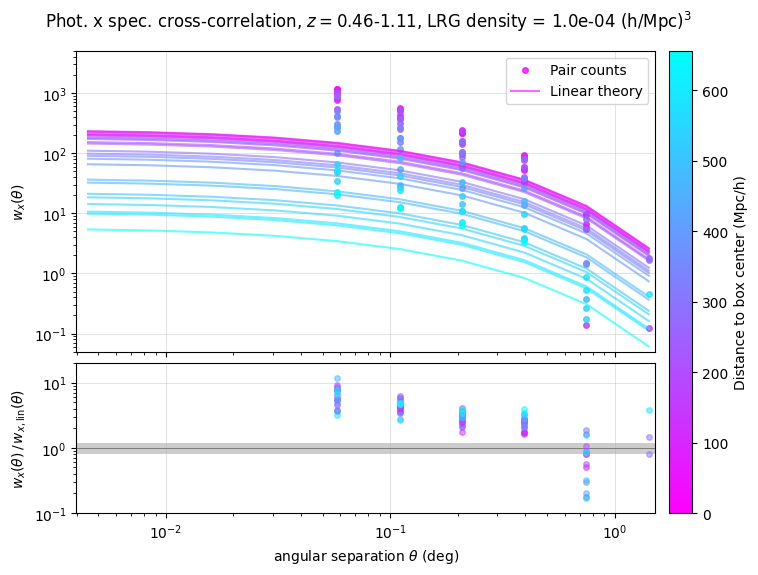

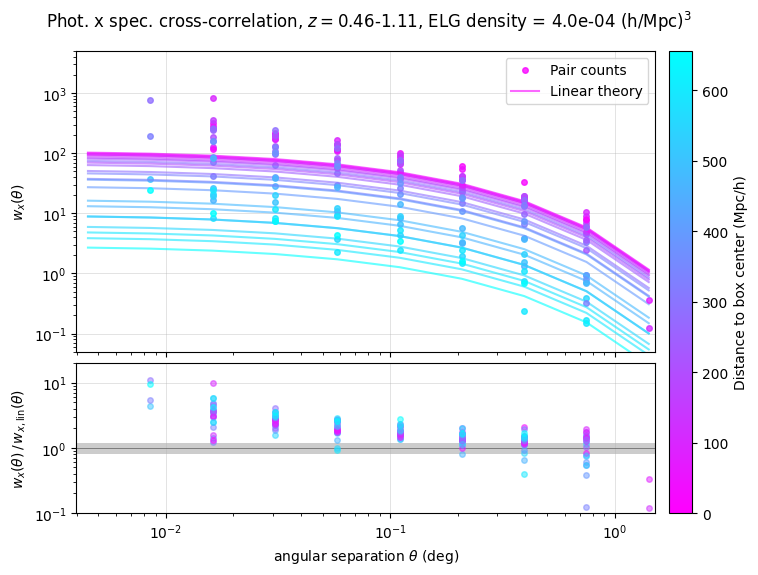

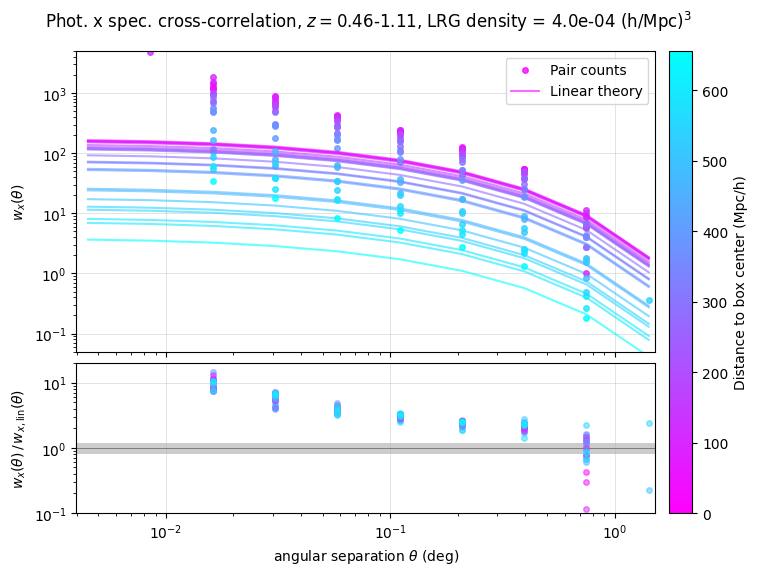

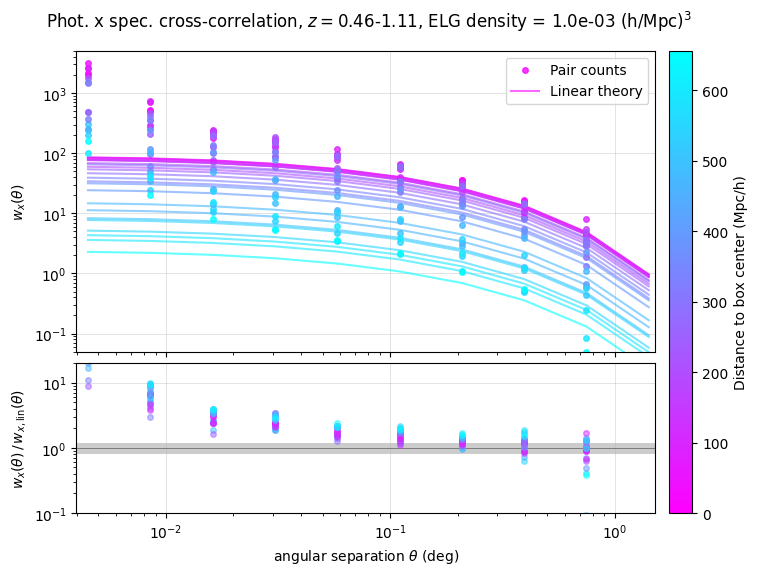

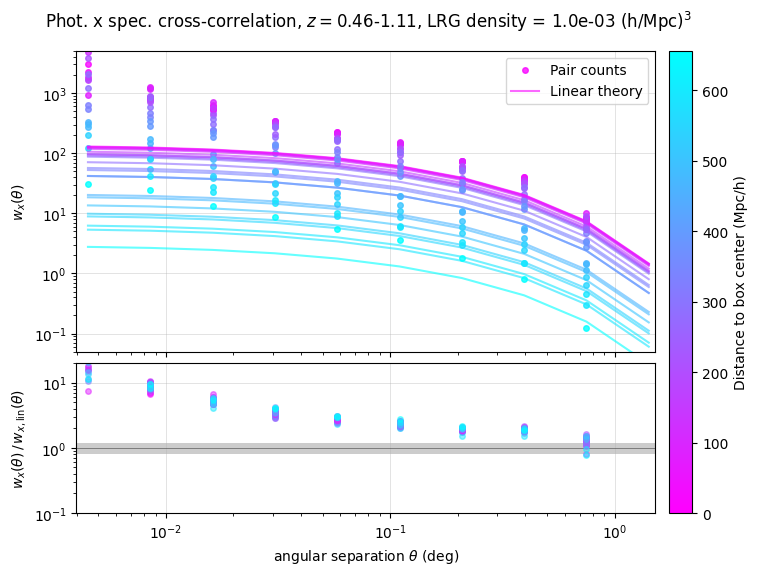

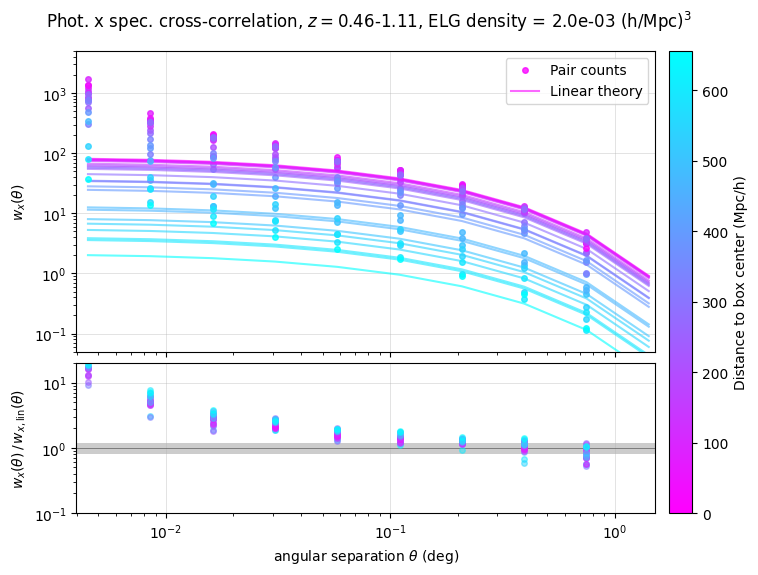

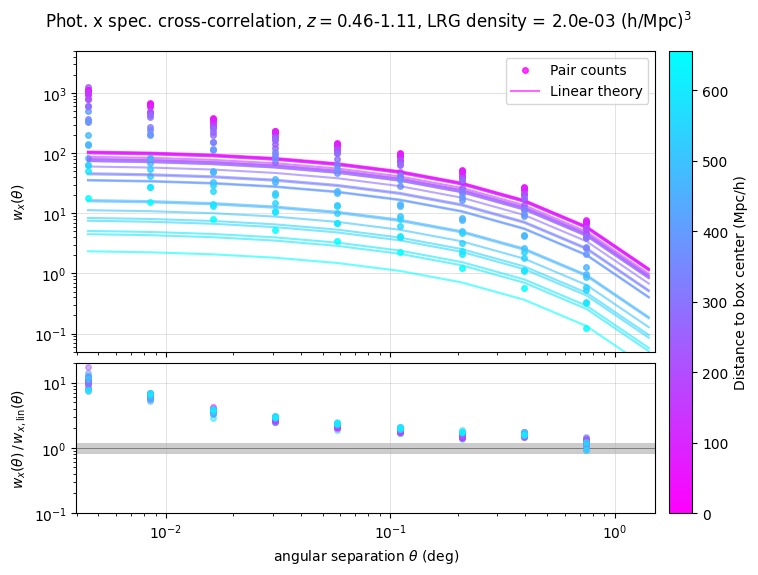

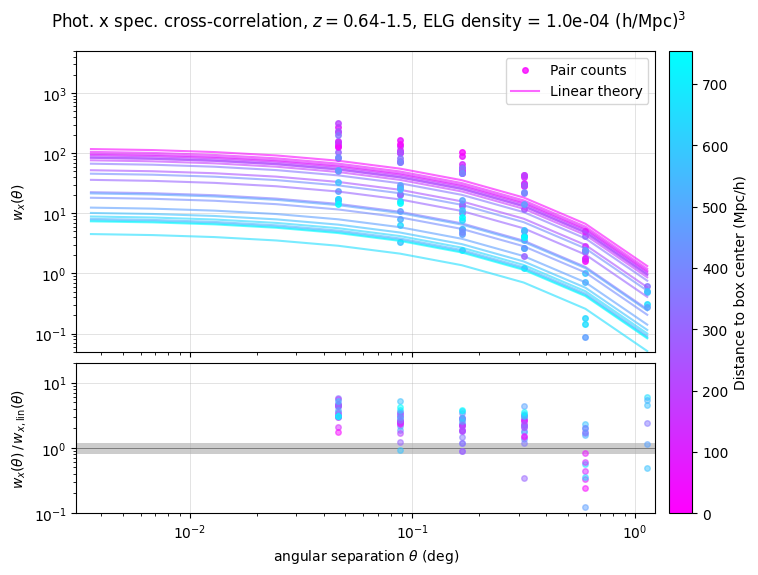

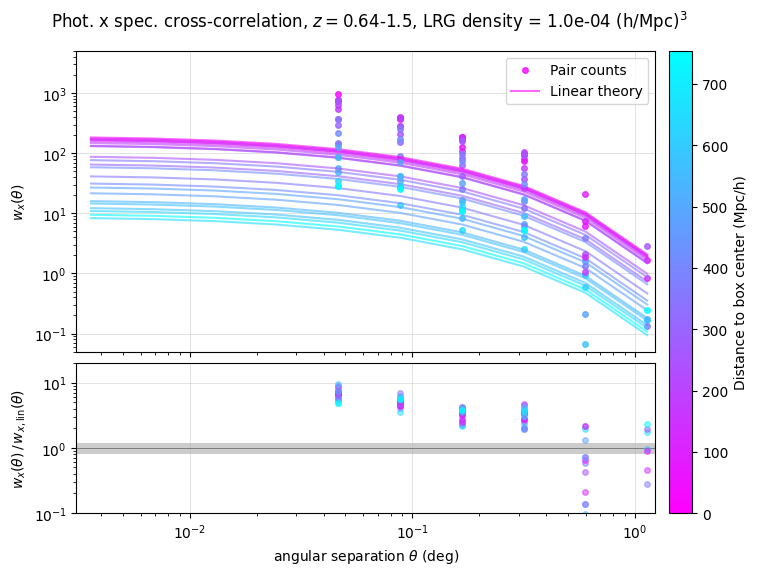

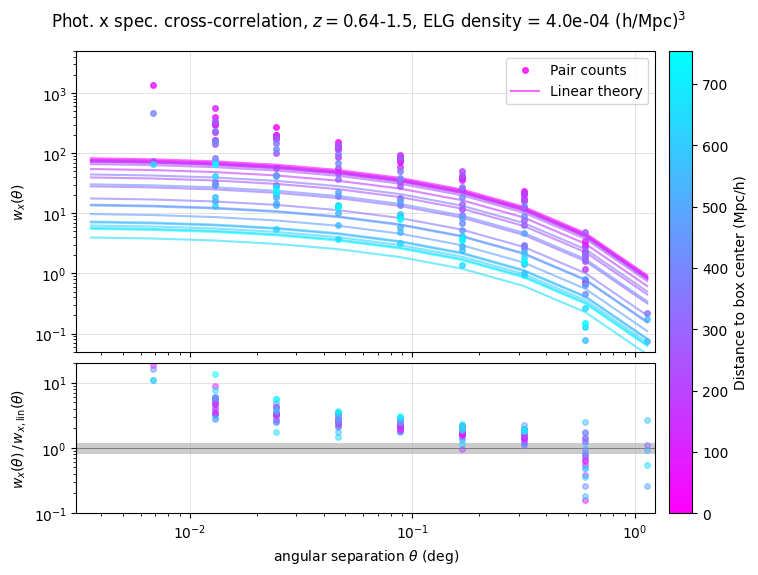

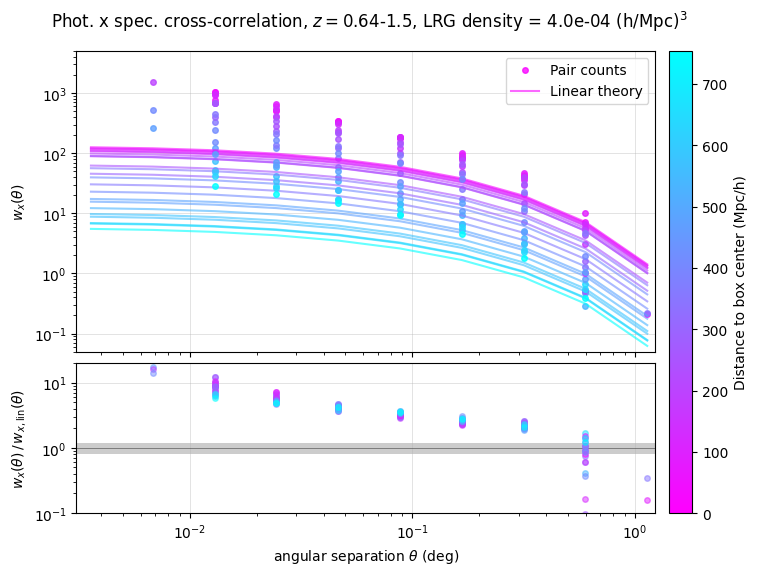

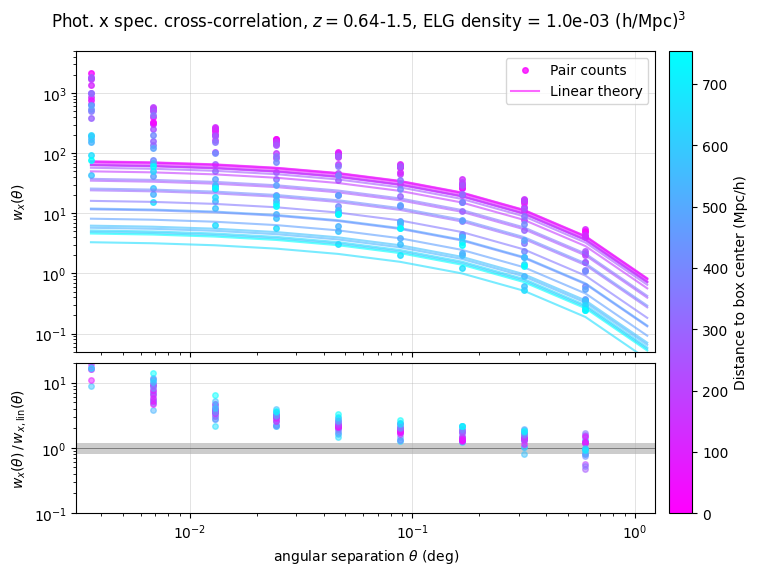

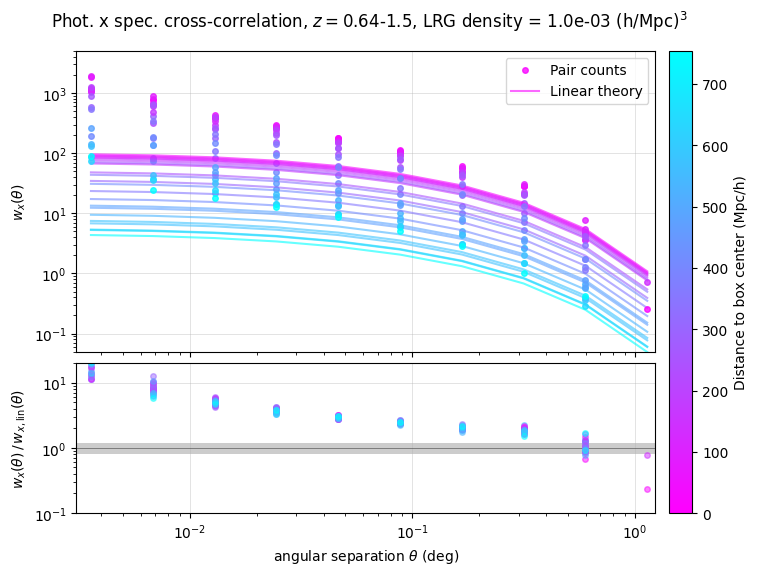

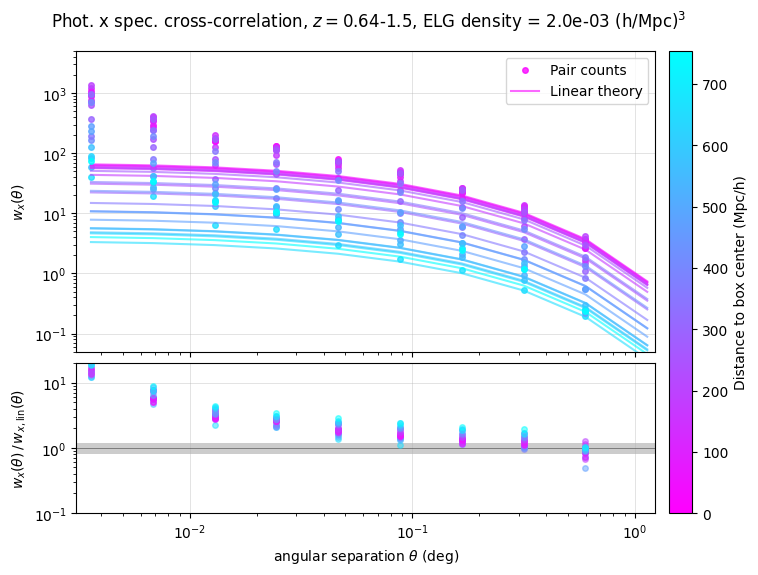

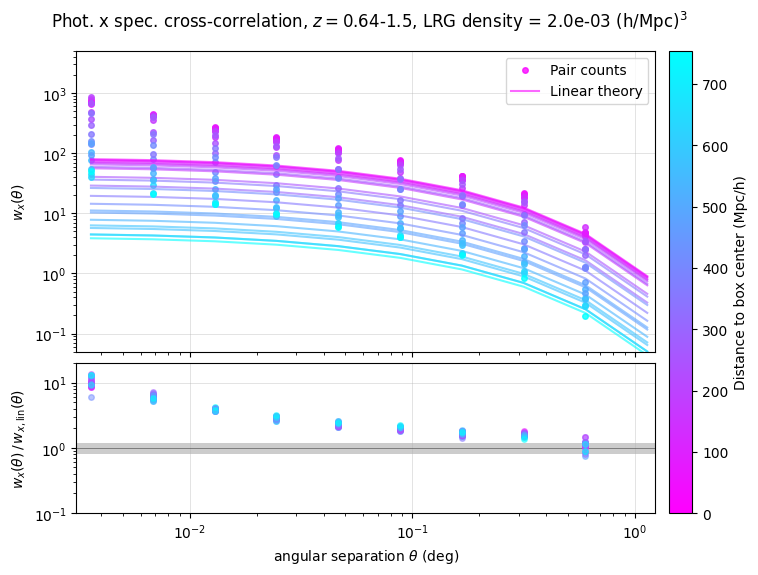

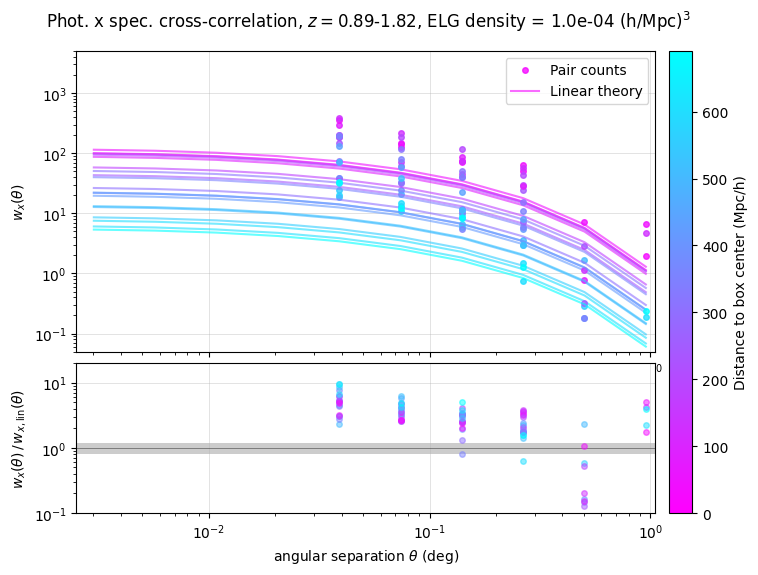

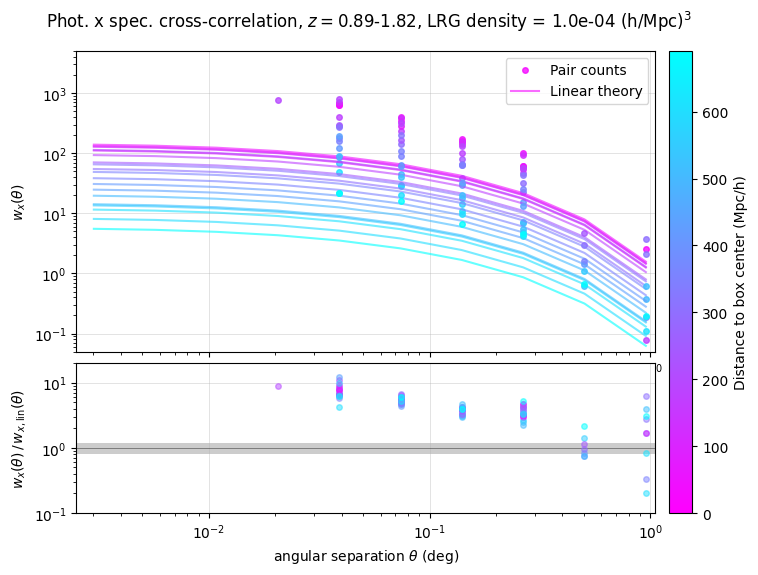

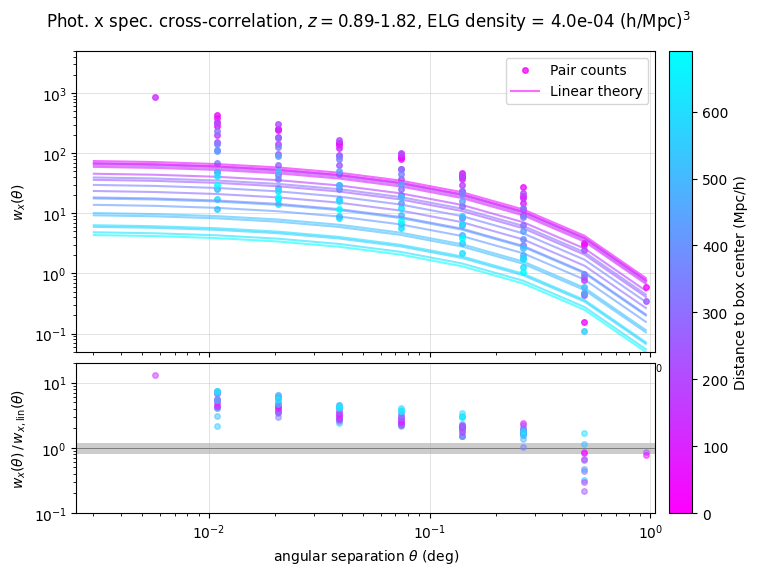

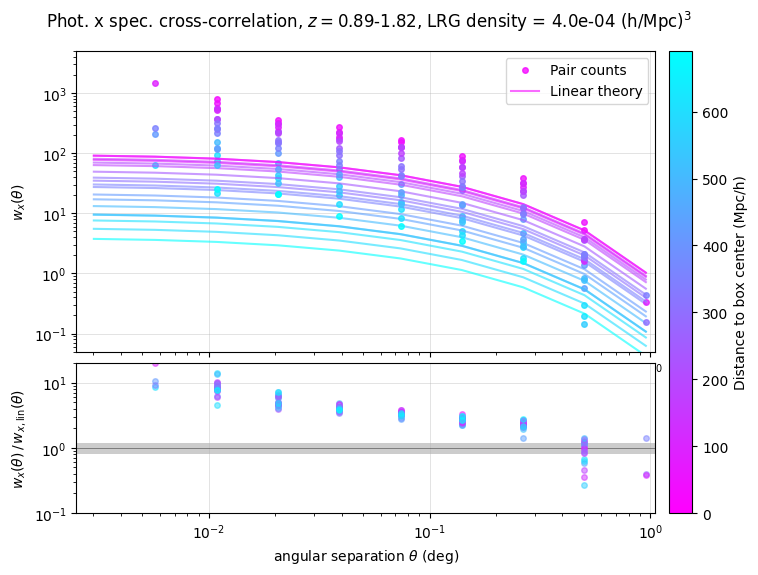

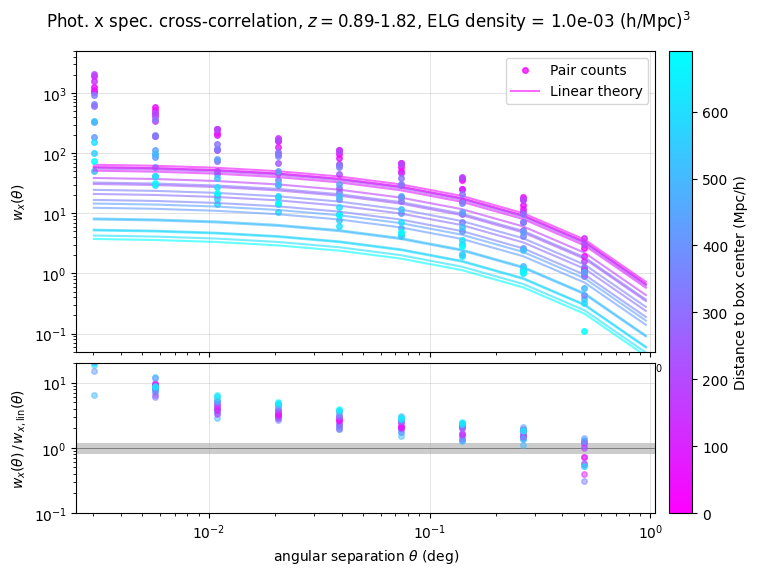

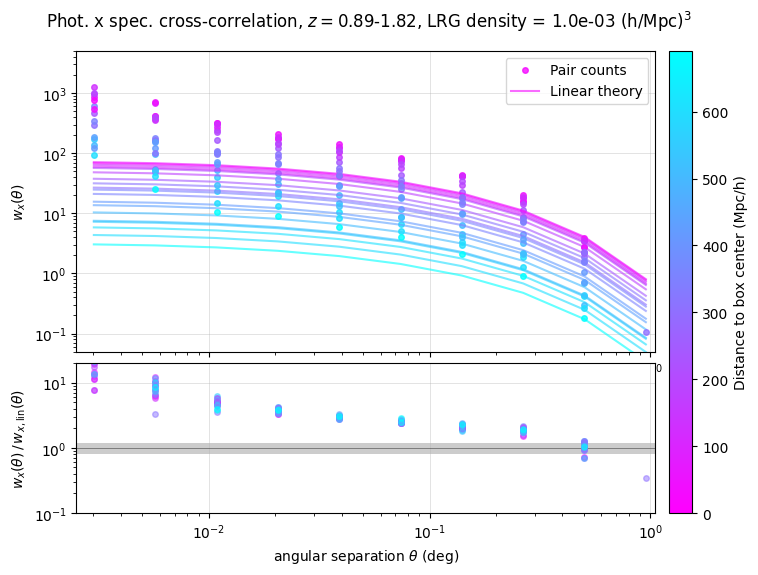

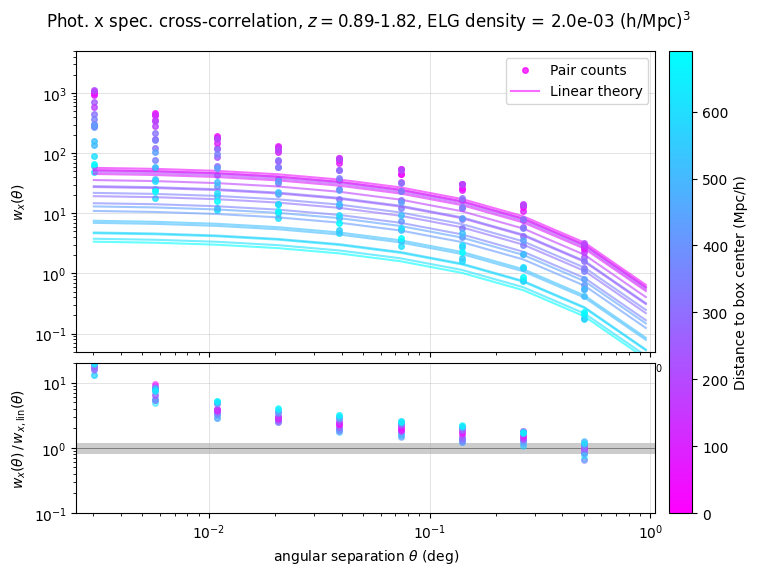

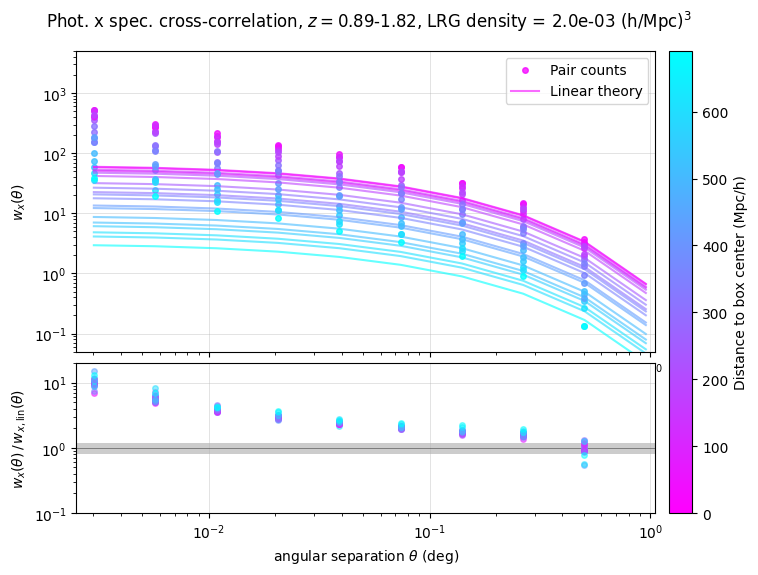

In [33]:
res_dicts = []

for (snapshots, photzbin) in zip(snapshotss, photzbins):
    for density in densities:
        for tracer in tracers:
    
            # instantiate
            X = HSC_Xcorr(snapshots, photzbin, density=density, reference_tracer=tracer, **hsc_kwargs)

            # load object
            density_tag = X.ns_tag
            if X.density_type == 'fixed':
                density_tag += f'-{X.density.value:.1e}'
            case_tag = f'z-{min(X.redshifts):.2f}-{max(X.redshifts):.2f}_photzbin{X.photzbin}' + density_tag + \
                        f'_{X.reference_survey}-{X.reference_tracer}'
            fn = os.path.join(X.scratch, 'TNG300-3/xcorr_res/HSC', f'z-{min(X.redshifts):.2f}-{max(X.redshifts):.2f}' + \
                              f'_photzbin{X.photzbin}{X.ns_tag}-{X.density.value:.1e}_{X.reference_survey}-{X.reference_tracer}',
                              'xcorr_object.pkl')
            del X
            with open(fn, 'rb') as file:
                Q = pickle.load(file)

            # plot the cross-correlations
            norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(Q.chis-Q.central_chi).value))
            smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
            fig = plt.figure(figsize=(9,6))
            gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.5], hspace=0.05)

            ax0 = fig.add_subplot(gs[0])
            for i, w in enumerate(Q.wthetax):
                kwargs = dict(c=smap.to_rgba(np.abs(Q.chis[i] - Q.central_chi).value))
                label = 'Pair counts' if i==len(Q.wthetax)//2 else ''
                ax0.plot(Q.theta_avg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
                label = 'Linear theory' if i==len(Q.wthetax)//2 else ''
                ax0.plot(Q.theta_avg, Q.wthetax_lin[i], alpha=0.6, label=label, **kwargs)
            # secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
            # secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
            ax0.set_ylim(5e-2,5e3)
            ax0.set_ylabel(r'$w_x(\theta)$')
            ax0.legend()

            ax1 = fig.add_subplot(gs[1])
            ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
            for i, w in enumerate(Q.wthetax):
                ax1.plot(Q.theta_avg, w / Q.wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
                         c=smap.to_rgba(np.abs(Q.chis[i] - Q.central_chi).value))
            ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
            ax1.set_ylim(1e-1, 2e1)
            ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
            ax1.set_xlabel(r'angular separation $\theta$ (deg)')

            for ax in (ax0, ax1):
                ax.loglog()
                ax.grid(alpha=0.5, lw=0.5)
                ax.set_xlim(min(Q.theta_avg)-5e-4, max(Q.theta_avg)+1e-1)

            fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center (Mpc/h)', pad=0.02)
            fig.suptitle(r'Phot. x spec. cross-correlation, $z=$'f'{min(Q.redshifts)}-{max(Q.redshifts)}' +
                         f', {Q.reference_tracer} density = {Q.density.value:.1e} (h/Mpc)'r'$^{3}$',
                         x=0.45, y=0.95)
            
            # construct result dictionary
            res_dict = {'snapshots' : Q.snapshots,
                        'redshifts' : Q.redshifts,
                        'chis' : Q.chis,
                        'central_chi' : Q.central_chi,
                        'photzbin' : Q.photzbin,
                        'density' : Q.density,
                        'tracer' : Q.reference_tracer,
                        'theta_avg' : Q.theta_avg,
                        'wthetax_data' : Q.wthetax,
                        'wthetax_lin' : Q.wthetax_lin
                       }
            res_dicts.append(res_dict)

### play around with other plotting strategies

/tmp/ipykernel_269448/2022022235.py:29: RuntimeWarning: Mean of empty slice
  mean, std = np.nanmean(ratio, axis=0), np.nanstd(ratio, axis=0)
/work2/08811/aew492/frontera/venv/illustris3.9/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


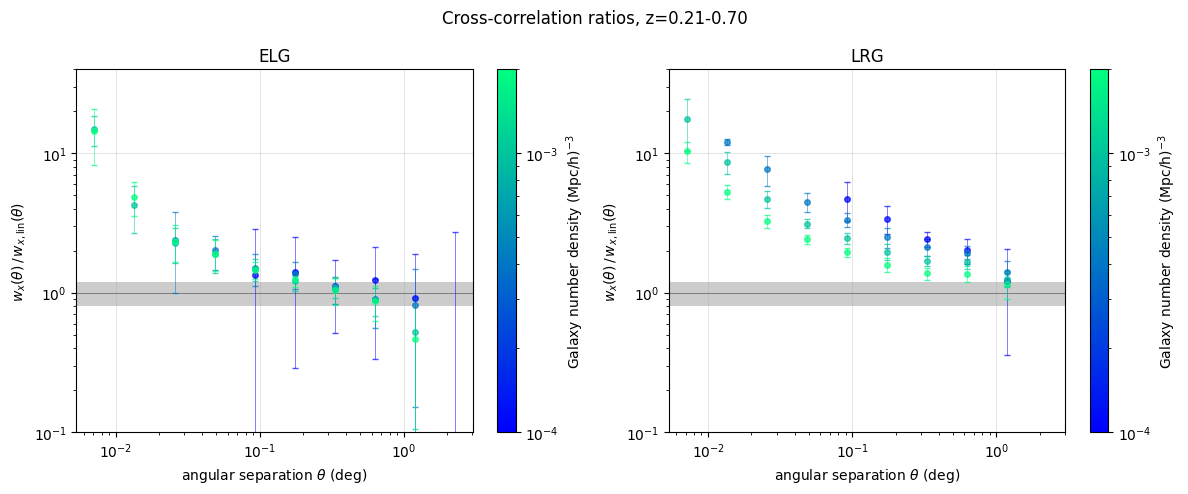

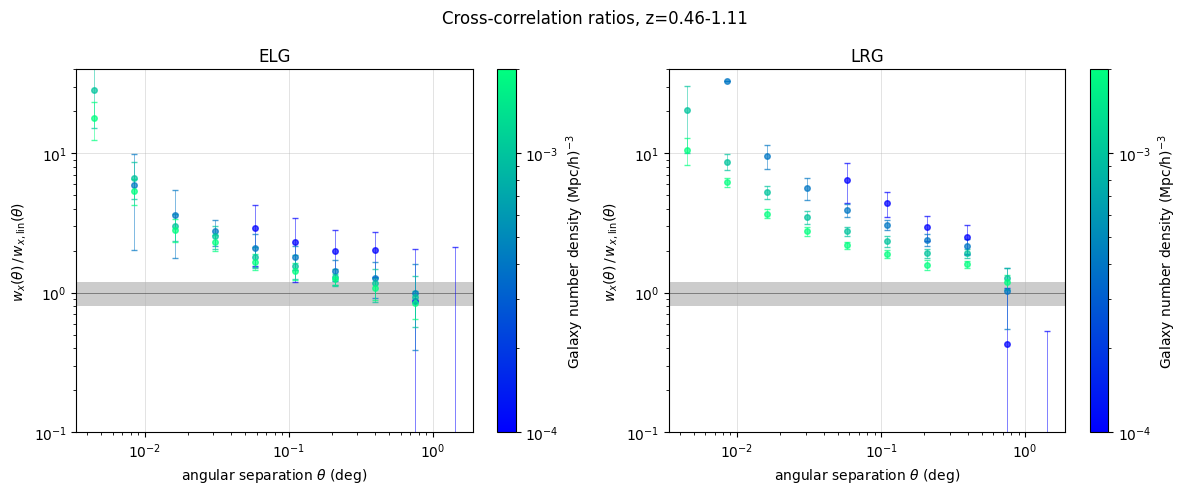

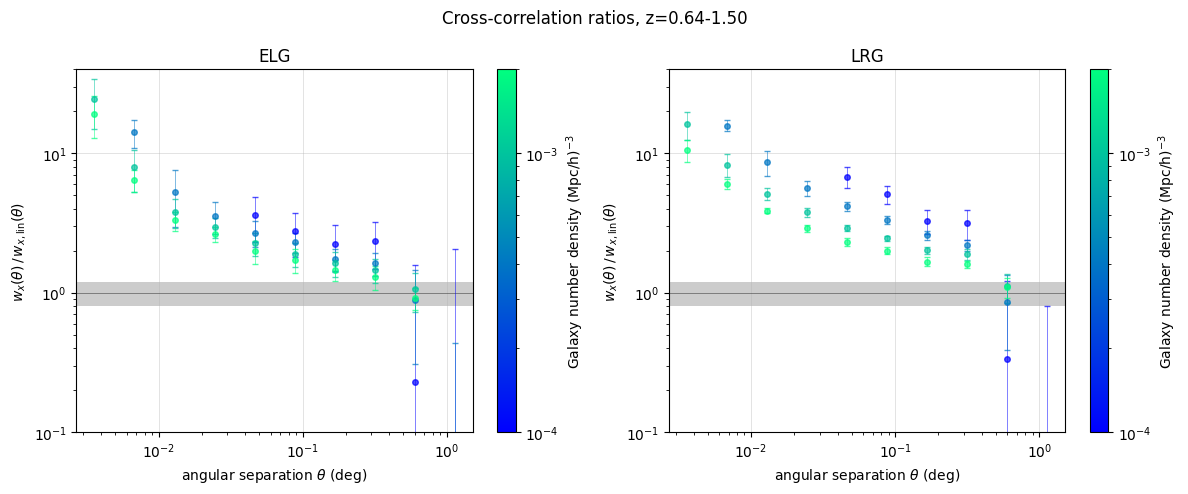

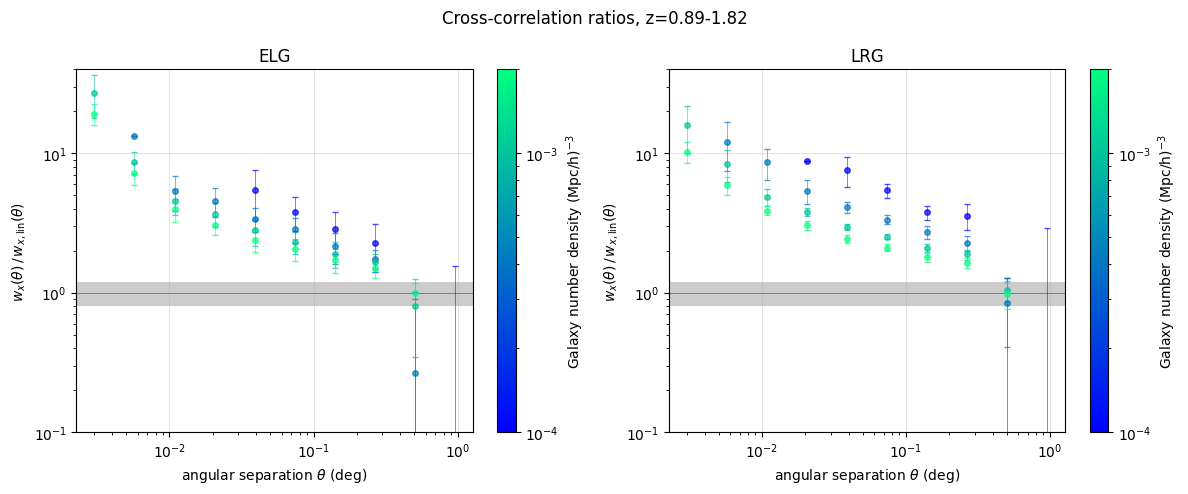

In [8]:
# colormap
norm = mpl.colors.LogNorm(vmin=min(densities).value, vmax=max(densities).value)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='winter')

for ibin in photzbins:
    
    fig, axs = plt.subplots(1, 2, figsize=(12,5), tight_layout=True)

    axs[0].set_title('ELG')
    axs[1].set_title('LRG')
    for ax in axs:
        ax.axhline(1., c='k', alpha=0.5, lw=0.5)
        ax.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
        ax.set_ylim(1e-1, 4e1)
        ax.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
        ax.set_xlabel(r'angular separation $\theta$ (deg)')
        ax.grid(alpha=0.5, lw=0.5)
        
    for res_dict in res_dicts:
        if res_dict['photzbin'] != ibin:
            continue
            
        # gather results
        zs = res_dict['redshifts']
        density = res_dict['density']
        label = f'density = {density.value:.0e} (Mpc/h)'r'$^{-3}$' # f'z={min(zs):.2f}-{max(zs):.2f}' +
        # mean and std ratio between data and theory
        ratio = res_dict['wthetax_data'] / res_dict['wthetax_lin']
        mean, std = np.nanmean(ratio, axis=0), np.nanstd(ratio, axis=0)

        # which axis
        ax = axs[0] if res_dict['tracer'] == 'ELG' else axs[1]
        # plot
        ax.errorbar(res_dict['theta_avg'], mean, yerr=std, alpha=0.7, lw=0.5,
                    marker='.', ms=8, capsize=2, ls='None',
                    c=smap.to_rgba(density.value), label=label)
    for ax in axs:
        ax.loglog()
        # ax.legend()
        fig.colorbar(smap, ax=ax, label=r'Galaxy number density (Mpc/h)$^{-3}$')
    fig.suptitle(f'Cross-correlation ratios, z={min(zs):.2f}-{max(zs):.2f}')

/tmp/ipykernel_269448/832179302.py:26: RuntimeWarning: Mean of empty slice
  mean, std = np.nanmean(ratio, axis=0), np.nanstd(ratio, axis=0)


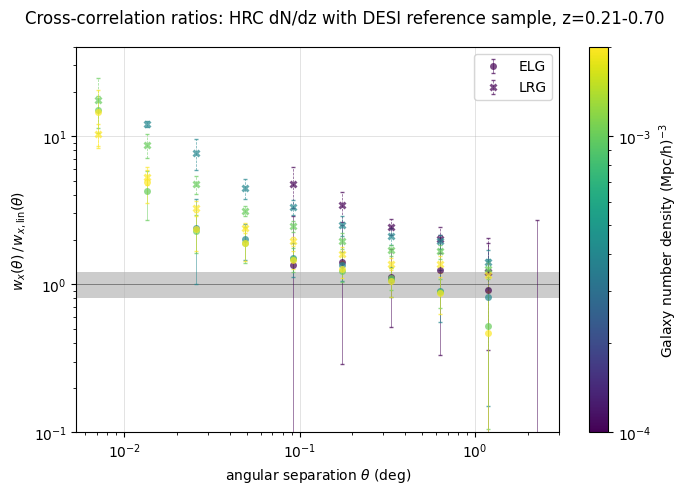

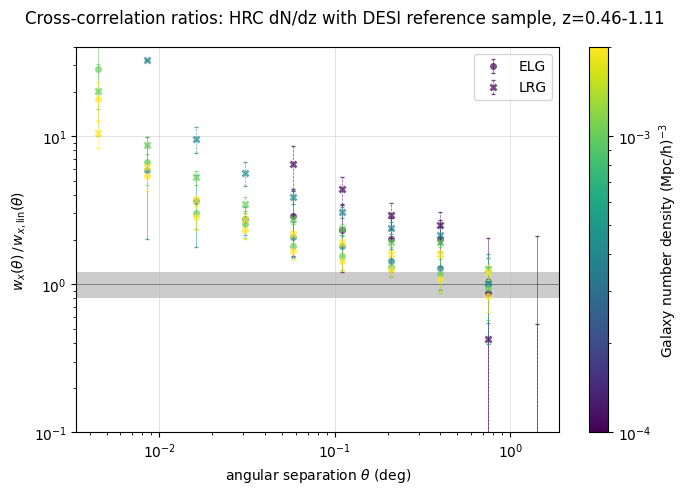

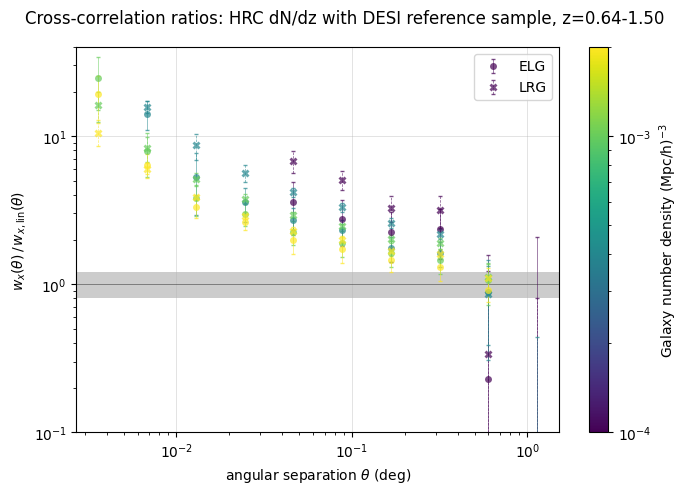

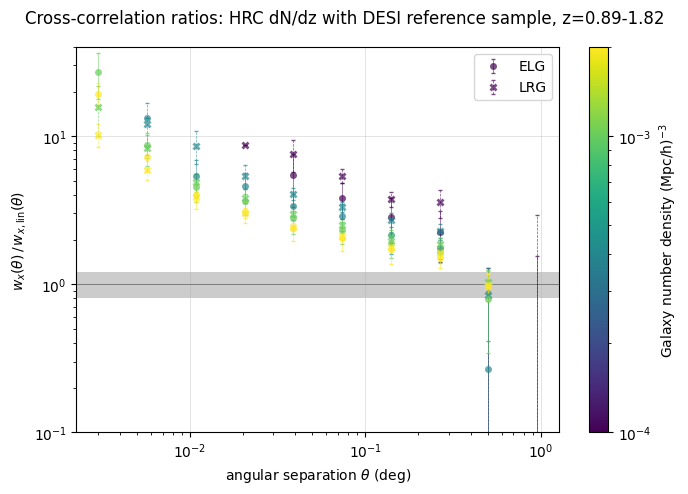

In [30]:
# colormap
norm = mpl.colors.LogNorm(vmin=min(densities).value, vmax=max(densities).value)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')

for ibin in photzbins:
    
    fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

    ax.axhline(1., c='k', alpha=0.5, lw=0.5)
    ax.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
    ax.set_ylim(1e-1, 4e1)
    ax.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
    ax.set_xlabel(r'angular separation $\theta$ (deg)')
    ax.grid(alpha=0.5, lw=0.5)
        
    ielg, ilrg = 0, 0 # to keep track of how many results I've plotted
    for res_dict in res_dicts:
        if res_dict['photzbin'] != ibin:
            continue
           
        # gather results
        zs = res_dict['redshifts']
        density = res_dict['density']
        # mean and std ratio between data and theory
        ratio = res_dict['wthetax_data'] / res_dict['wthetax_lin']
        mean, std = np.nanmean(ratio, axis=0), np.nanstd(ratio, axis=0)

        # tracer-specific variables
        if res_dict['tracer'] == 'ELG':
            mec, c = 'None', smap.to_rgba(density.value)
            marker = 'o'
            ms = 5
            label = 'ELG' if ielg == 0 else ''
            ebls = '-'
            ielg += 1
        else:
            assert res_dict['tracer'] == 'LRG'
            mec, c = 'None', smap.to_rgba(density.value)
            marker = 'X'
            ms = 6
            label = 'LRG' if ilrg == 0 else ''
            ebls = '--'
            ilrg += 1
        
        # plot
        eb = ax.errorbar(res_dict['theta_avg'], mean, yerr=std, alpha=0.7, lw=0.5,
                    marker=marker, ms=ms, capsize=1.5, ls='None',
                    mec=mec, c=c, label=label)
        eb[-1][0].set_linestyle(ebls) #eb[-1][0] is the LineCollection objects of the errorbar lines
        
        i += 1

    ax.loglog()
    ax.legend()
    fig.colorbar(smap, ax=ax, label=r'Galaxy number density (Mpc/h)$^{-3}$')
    fig.suptitle(f'Cross-correlation ratios: HRC dN/dz with DESI reference sample, z={min(zs):.2f}-{max(zs):.2f}')